# **Tutorial 3: Visualizing Satellite CDR - Global Vegetation Mapping**

**Week 1, Day 3, Remote Sensing**

**Content creators:** Douglas Rao

**Content reviewers:** Katrina Dobson, Younkap Nina Duplex, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Jenna Pearson, Agustina Pesce, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS and Google DeepMind

# **Tutorial Objectives**

In this tutorial, you will acquire skills necessary for accessing and analyzing satellite remote sensing products, particularly in the context of climate applications. We will be using vegetation mapping as an example, and use long-term vegetation greeness data to demonstrate these skills.

By the end of this tutorial you will be able to:

* Locate, access, and visualize vegetation greeness data (NDVI) from the cloud using `xarray` and `matplotlib`.
* Understand how to use quality flag information included in the datasets to filter out data that is not acceptable to use for climate analysis.


# **Setup**

In [1]:
# !pip install s3fs --quiet
# !pip install cartopy --quiet

In [10]:
# imports
import s3fs
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import datetime
import boto3
import botocore
import pooch
import os
import tempfile


In [11]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

In [12]:
# @title Video 1: Video 1 Name
#Tech team will add code to format and display the video

In [13]:
# helper functions

def pooch_load(filelocation='',filename=''):
    shared_location='/home/jovyan/shared/data/tutorials/W1D3_RemoteSensingLandOceanandAtmosphere' # this is different for each day
    user_temp_cache=tempfile.gettempdir()
    
    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename))

    return file

# **Section 1: Satellite Monitoring of Vegetation Status**

As we learned in the previous tutorial, all the **National Atmospheric and Oceanic Administration Climate Data Record (NOAA-CDR)** datasets are available both at NOAA National Centers for Environmental Information (NCEI) and commercial cloud platforms. Here, we are accessing the data directly via the **Amazon Web Service (AWS)**. You can find out information about the NOAA CDRs on AWS's Open Data Registry.

* [NOAA Fundamental CDR on AWS](https://registry.opendata.aws/noaa-cdr-fundamental/) 
* [NOAA Terrestrial CDR on AWS](https://registry.opendata.aws/noaa-cdr-terrestrial/) 
* [NOAA Atmospheric CDR on AWS](https://registry.opendata.aws/noaa-cdr-atmospheric/) 
* [NOAA Oceanic CDR on AWS](https://registry.opendata.aws/noaa-cdr-oceanic/) 

The index we will use in this tutorial is the **Normalized Difference Vegetation Index (NDVI)**.  It is one of the most commonly used remotely sensed indices. It measures the "greeness" of vegetation, and is useful in understanding vegetation density and assessing changes in plant health. For example, NDVI can be used to study the impact of drought, heatwave, and insect infestation on plants covering Earth's surface.

## **Section 1.1: Access NOAA NDVI CDR Data from AWS**



If we go to the [cloud storage space (or a S3 bucket)](https://noaa-cdr-ndvi-pds.s3.amazonaws.com/index.html#data/) that hosts NOAA NDVI CDR data, you will see the pattern of how the NOAA NDVI CDR is organized:

`s3://noaa-cdr-ndvi-pds/data/1981/AVHRR-Land_v005_AVH13C1_NOAA-07_19810624_c20170610041337.nc`

We can take advantage of the pattern to search for the data file systematically. 

> Parent directory: `s3://noaa-cdr-ndvi-pds/data/`  
> Sub-directory for each year: `1981/`  
> File name of each day: `AVHRR-Land_v005_AVH13C1_NOAA-07_19810624_c20170610041337.nc`

The file name also has a clear pattern:

> Sensor name: `AVHRR`  
> Product category: `Land`  
> Product version: `v005`  
> Product code: `AVH13C1`  
> Satellite platform: `NOAA-07`  
> Date of the data: `19810624`  
> Processing time: `c20170610041337` (*This will change for each file based on when the file was processed*)  
> File format: `.nc` (*netCDR-4 format*)

In other words, if we are looking for the data of a specific day, we can easily locate where the file might be. 

For example, if we want to find the AVHRR data for the day of *2002-03-12 (or March 12, 2002)*, you can use:

`s3://noaa-cdr-ndvi-pds/data/2002/AVHRR-Land_v005_AVH13C1_*_20020312_c*.nc`

The reasaon that we put `*` in the above directory is because we are not sure about what satellite platform this data is from and when the data was processed. The `*` is called a **wildcard**, and is used because we want *all* the files that contain our specific criteria, but do not want to have to specify all the other pieces of the filename we are not sure about yet. It should return all the data satisfying that initial criteria and you can refine further once you see what is available. Essentially, this first step helps to narrow down the data search.

In [14]:
# to access the NDVI data from AWS S3 bucket, we first need to connect to s3 bucket
fs = s3fs.S3FileSystem(anon=True)

# we can now check to see if the file exist in this cloud storage bucket using the file name pattern we just described
date_sel = datetime.datetime(2002,3,12,0) # select a desired date and hours (midnight is zero)

# automatic filename from data_sel. we use strftime (string format time) to get the text format of the file in question. 
file_location = fs.glob('s3://noaa-cdr-ndvi-pds/data/'+
                        date_sel.strftime('%Y')+'/AVHRR-Land_v005_AVH13C1_*'+
                        date_sel.strftime('%Y%m%d')+'_c*.nc')
# now let's check if there is a file match the pattern of the date that we are interested in.
file_location

['noaa-cdr-ndvi-pds/data/2002/AVHRR-Land_v005_AVH13C1_NOAA-16_20020312_c20170321233653.nc']

### **Coding Exercises 1.1**

1. NDVI CDR data switched sensors on 2014 from AVHRR (the older generation sensor) to VIIRS (the newest generation sensor). Using the code above and the [list of data names](https://noaa-cdr-ndvi-pds.s3.amazonaws.com/index.html#data/) for VIIRS, find data from a day after 2014. You will need to modify string input into `glob()` to do so.

In [7]:
#################################################
# Students: Fill in missing code (...) and comment or remove the next line
raise NotImplementedError("Student exercise: Choose identify the location of the NDVI CDR data on Amazon Web Service for a day after 2014.")
#################################################

exercise_date_sel = ... # select a desired date and hours (midnight is zero)

# automatic filename from data_sel. we use strftime (string format time) to get the text format of the file in question. 
exercise_file_location = ...

# now let's check if there is a file match the pattern of the date that we are interested in.
exercise_file_location

NotImplementedError: Student exercise: Choose identify the location of the NDVI CDR data on Amazon Web Service for a day after 2014.

In [15]:
# to_remove solution

exercise_date_sel = datetime.datetime(2020,1,1,0) # select a desired date and hours (midnight is zero)

# automatic filename from data_sel. we use strftime (string format time) to get the text format of the file in question. 
exercise_file_location = fs.glob('s3://noaa-cdr-ndvi-pds/data/'+
                        exercise_date_sel.strftime('%Y')+'/VIIRS-Land_v001-preliminary_NPP13C1_S-NPP_*'+
                        exercise_date_sel.strftime('%Y%m%d')+'*.nc')

# now let's check if there is a file match the pattern of the date that we are interested in.
exercise_file_location

['noaa-cdr-ndvi-pds/data/2020/VIIRS-Land_v001-preliminary_NPP13C1_S-NPP_20200101_c20220419001028.nc']

## **Section 1.2: Read NDVI CDR Data**

Now that you have the location of the NDVI data for a specific date, you can read in the data using the python library `xarray` to open the [netCDF-4 file](https://pro.arcgis.com/en/pro-app/latest/help/data/multidimensional/what-is-netcdf-data.htm), a common data format used to store satellite and climate datasets.



In [16]:
# first, we need to open the connection to the file object of the selected date.
# we are still using the date of 2002-03-12 as the example here.

# to keep up with previous tutorials (consistency), we are going to use boto3 and pooch to open the file. 
# but note s3fs also has the ability to open files from s3 remotely.  

client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED)) # initialize aws s3 bucket client

ds = xr.open_dataset(pooch_load(filelocation='http://s3.amazonaws.com/'+file_location[0],filename=file_location[0])) # open the file
ds 

<xarray.Dataset>
Dimensions:    (latitude: 3600, longitude: 7200, time: 1, ncrs: 1, nv: 2)
Coordinates:
  * latitude   (latitude) float32 89.97 89.93 89.88 ... -89.88 -89.93 -89.97
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time       (time) datetime64[ns] 2002-03-12
Dimensions without coordinates: ncrs, nv
Data variables:
    crs        (ncrs) int16 ...
    lat_bnds   (latitude, nv) float32 ...
    lon_bnds   (longitude, nv) float32 ...
    NDVI       (time, latitude, longitude) float32 ...
    TIMEOFDAY  (time, latitude, longitude) datetime64[ns] ...
    QA         (time, latitude, longitude) int16 ...
Attributes: (12/48)
    title:                                  Normalized Difference Vegetation ...
    institution:                            NASA/GSFC/SED/ESD/HBSL/TIS/MODIS-...
    Conventions:                            CF-1.6, ACDD-1.3
    standard_name_vocabulary:               CF Standard Name Table (v25, 05 J...
    naming_authority:                       gov.noaa.ncei
    license:                                See the Use Agreement for this CD...
    ...                                     ...
    PercentValidDaytimeData:                34.50
    PercentValidDaytimeLand:                34.50
    PercentValidClearDaytimeLand:           4.42
    PercentValidDaytimeLandInCloudShadow:   0.90
    PercentValidClearDaytimeWater:          0.00
    PercentValidDaytimeWaterInCloudShadow:  0.00

The output from the code block tells us that the NDVI data file of 2002-03-12 has dimensions of `3600x7200`. This makes sense for a dataset with the spatial resolution of 0.05°×0.05° that spans 180° of latitude and 360° of longitude. There is another dimension of the dataset named `time`. Since it is a daily data file, it only contains one value.

Two main data variables are in this dataset are `NDVI` and `QA`.

* `NDVI` is the variable that contains the value of Normalized Difference Vegetation Index  (NDVI - ranges between -1 and 1) that can be used to measure the vegetation greeness.  
* `QA` is the variable that indicates the quality of the NDVI values for each corresponding grid. It reflects whether the data is of high quality or should be discarded because of various reasons (e.g., bad sensor data, potentially contanminated by clouds).



## **Section 1.3: Visualize NDVI CDR Data**

In [17]:
# examine NDVI values from the dataset
ndvi = ds.NDVI
ndvi

<xarray.DataArray 'NDVI' (time: 1, latitude: 3600, longitude: 7200)>
[25920000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 89.97 89.93 89.88 ... -89.88 -89.93 -89.97
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time       (time) datetime64[ns] 2002-03-12
Attributes:
    long_name:      NOAA Climate Data Record of Normalized Difference Vegetat...
    units:          1
    valid_range:    [-1000 10000]
    grid_mapping:   crs
    standard_name:  normalized_difference_vegetation_index

To visualize the raw data, we will will plot it using `matplotlib` by calling `.plot()` on our xarray `DataArray`.

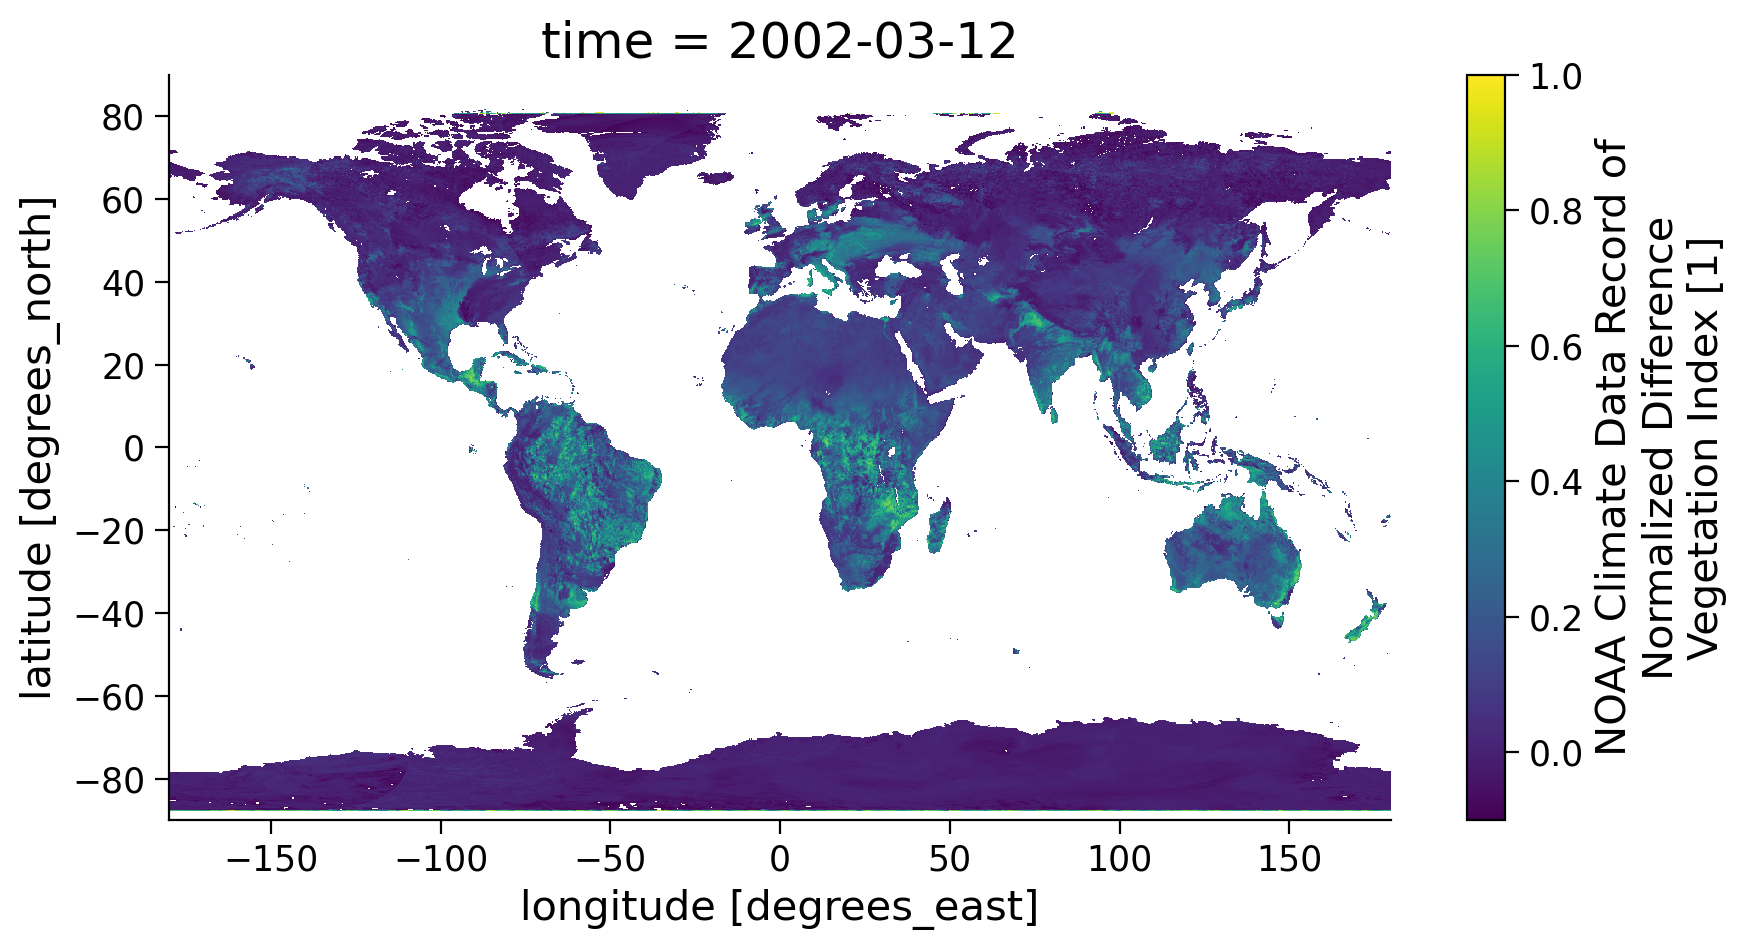

In [18]:
# figure settings:
# vmin & vmax: minimum and maximum values for the legend
# aspect: setting the aspect ratio of the figure, must be combined with `size`
# size: setting the overall size of the figure

# to make plotting faster and less memory intesive we use coarsen to reduce the number of pixels
ndvi.coarsen(latitude=5).mean().coarsen(longitude=5).mean().plot(vmin=-0.1, vmax=1.0, aspect=1.8, size=5)



## **Section 1.4: Mask NDVI Data Using a Quality Flag**

As stated earlier, there is also a variable `QA` that indicates the quality of the NDVI value for each grid cell. This quality information is very important when using satellite data to ensure the climate analysis is done using only the highest quality data.

For NDVI CDR data, it has a complex quality flag system that is represented using a 16-bit system. Although when you explore the values of `QA`,= it appears to be normal numeric values, the QA value needs to be converted to binary values of 16 bits and recognize the quality flag based on the information listed in the table below. 

| Bit No. | Description | Value=1 | Value=0 |
|-:|:-|:-:|:-:|
|15|Flag to indicate if the pixel is in polar region|Yes|No|
|14|Flag to indicate BRDF-correction issues|Yes|No|
|13|Flag to indicate RH03 value is invalid|Yes|No|
|12|Flag to indicate AVHRR Channel 5 value is invalid|Yes|No|
|11|Flag to indicate AVHRR Channel 4 value is invalid|Yes|No|
|10|Flag to indicate AVHRR Channel 3 value is invalid|Yes|No|
| 9|Flag to indicate AVHRR Channel 2 value is invalid|Yes|No|
| 8|Flag to indicate AVHRR Channel 1 value is invalid|Yes|No|
| 7|Flag to indicate all 5 AVHRR Channels are valid|Yes|No|
| 6|Flag to indicate the pixel is at night (no visible channel data)|Yes|No|
| 5|Flag to indicate the pixel is over dense dark vegetation|Yes|No|
| 4|Flag to indicate the pixel is over sunglint (over ocean)|Yes|No|
| 3|Flag to indicate the pixel is over water|Yes|No|
| 2|Flag to indicate the pixel contains cloud shadow|Yes|No|
| 1|Flag to indicate the pixel is cloudy|Yes|No|
| 0|(Unused)|Yes|No|

This shows the complex system to ensure that satellite CDR data is of high quality for climate applications. But how can we decifer the quality of a given pixel? 

Assuming that we have a grid with `QA=18`, when converted into a binary value with the length of 16 bits it becomes `0000000000010010`. That is, every `QA` value will be convereted into a list of 1's and 0's that is 16 numbers long. Converting our example above of 18 we have:

|Bit15|Bit14|Bit13|Bit12|Bit11|Bit10|Bit9|Bit8|Bit7|Bit6|Bit5|Bit4|Bit3|Bit2|Bit1|Bit0|
|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|
|0|0|0|0|0|0|0|0|1|0|0|1|0|0|1|0|
|No|No|No|No|No|No|No|No|Yes|No|No|Yes|No|No|Yes|No|

Note here that 1 is `True` and 0 is `False`. Interpreting the table above, for a quality flag of 18, the NDVI is retrieved from valid values of AVHRR channels (`Bit7=1`) and the grid is over dense dark vegetation (`Bit5=1`), but the grid is cloudy (`Bit1=1`). Therefore, the QA tells us that we should not use this grid since it is covered by clouds and does not reflect vegetation information on the land surface. 

If you are a little confused by how to convert to binary, that is ok! This is a skill that you can practice more in your projects. For this tutorial, we will define a function that will automate our selection process of avoiding cloudy data.

In [19]:
# define a function to extract high quality NDVI data
def get_quality_info(QA):
  """
  QA: the QA value read in from the NDVI data

  High quality NDVI should meet the following criteria:
  Bit 7: 1 (All AVHRR channels have valid values)
  Bit 2: 0 (The pixel is not covered by cloud shadow)
  Bit 1: 0 (The pixel is not covered by cloud)

  Output:
  True: high quality
  False: low quality
  """
  # unpack quality assurance flag for cloud (byte: 1)
  cld_flag = (QA % (2**2)) // 2;
  # unpack quality assurance flag for cloud shadow (byte: 2)
  cld_shadow = (QA % (2**3)) // 2**2;
  # unpack quality assurance flag for AVHRR values (byte: 7)
  value_valid = (QA % (2**8)) // 2**7;

  mask = (cld_flag == 0) & (cld_shadow == 0) & (value_valid ==1)

  return mask

In [20]:
# get the quality assurance value from NDVI data
QA = ds.QA

# create the high quality information mask
mask = get_quality_info(QA)

# check the quality flag mask information
mask

<xarray.DataArray 'QA' (time: 1, latitude: 3600, longitude: 7200)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * latitude   (latitude) float32 89.97 89.93 89.88 ... -89.88 -89.93 -89.97
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time       (time) datetime64[ns] 2002-03-12

The output of the previous operation gives us a data array with logical values to indicate if a grid has high quality NDVI values or not. Now let's mask out the NDVI data array with this quality information to see if this will make a difference in the final map.

In [21]:
# use `.where` to only keep the NDVI values with high quality flag
ndvi_masked = ndvi.where(mask)
ndvi_masked

<xarray.DataArray 'NDVI' (time: 1, latitude: 3600, longitude: 7200)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 89.97 89.93 89.88 ... -89.88 -89.93 -89.97
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time       (time) datetime64[ns] 2002-03-12
Attributes:
    long_name:      NOAA Climate Data Record of Normalized Difference Vegetat...
    units:          1
    valid_range:    [-1000 10000]
    grid_mapping:   crs
    standard_name:  normalized_difference_vegetation_index

As you may have noticed, a lot of the NDVI values in the masked data array becomes `nan` which means `not a number`. This means that the grid does not have a high quality NDVI value based on the QA value. Now, let's plot the map one more time to see the difference after the quality masking.

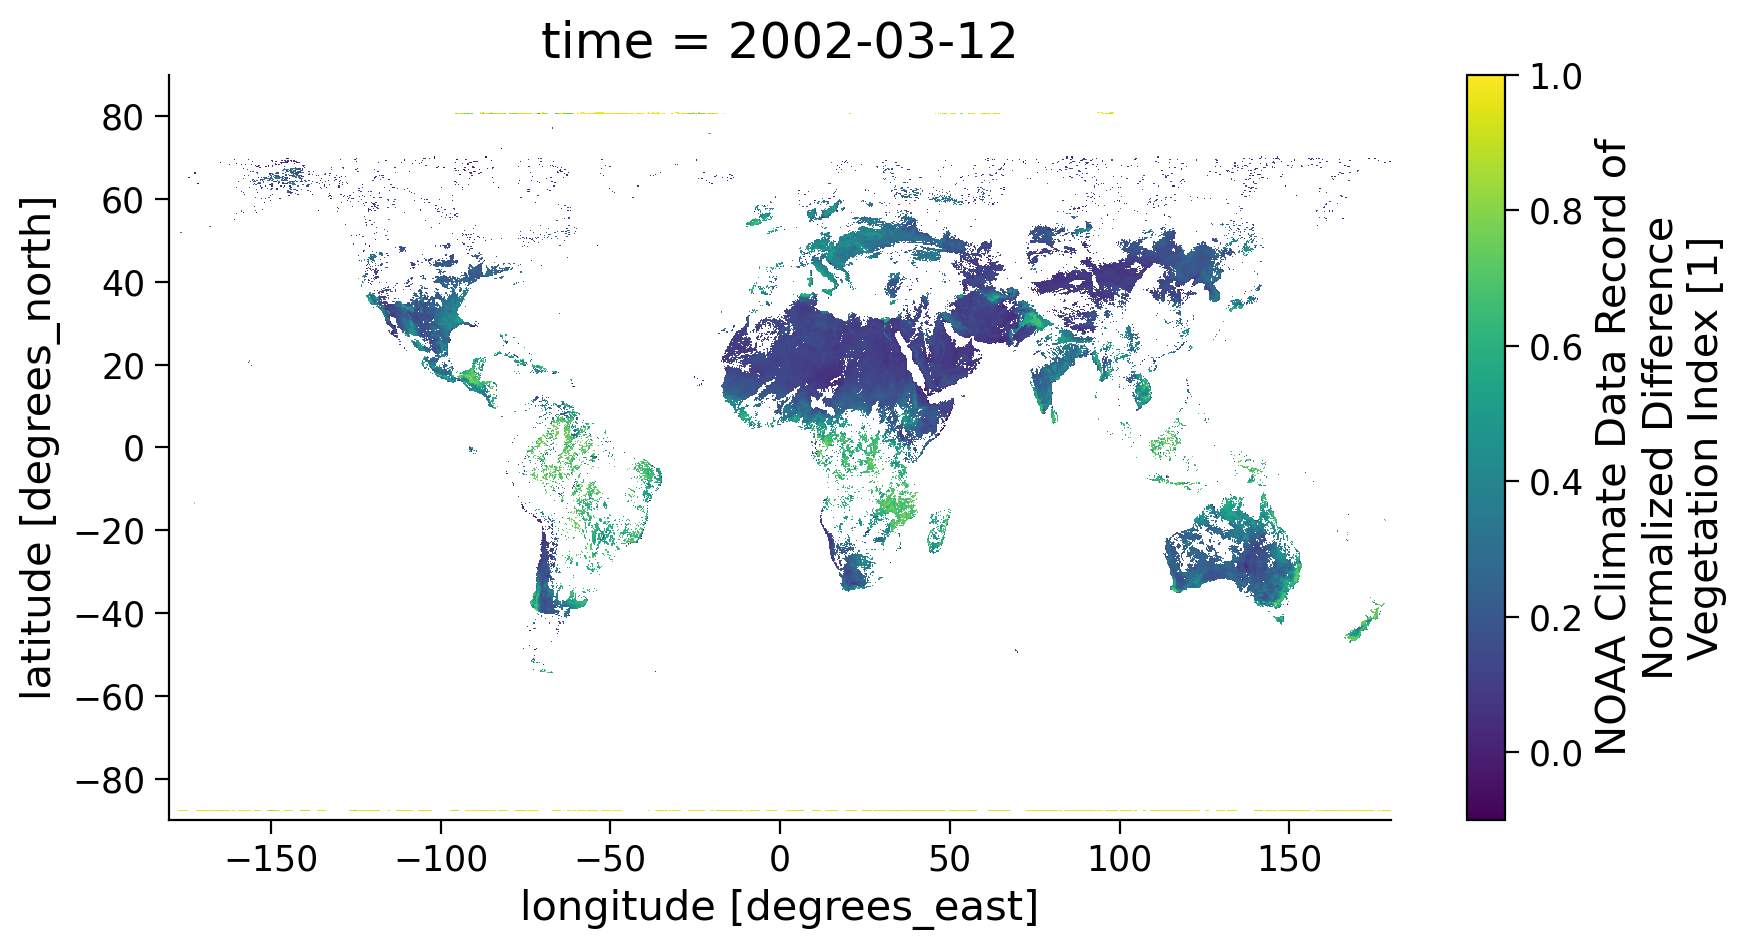

In [22]:
# re-plot the NDVI map using masked data
ndvi_masked.coarsen(latitude=5).mean().coarsen(longitude=5).mean().plot(vmin=-0.1, vmax=1.0, aspect=1.8, size=5)


Note the large difference after the quality mask was applied and you removed data that was compromised due to clouds. Since the NDVI value is calculated using the reflectance values of the red and near-infrared spectral band, this value is only useful for vegetation and surface monitoring when there are no clouds present. Thus, we always need to remove the grid with clouds in the data.

### **Coding Exercises 1.4**

You just learned how to use `xarray` and `matplotlib` to access NDVI CDR data from AWS and visualize it. Can you find a different date that you are interested in and visualize the high quality NDVI data of that day? Note the solution is just an example of a date that you could choose.

In [ ]:
#################################################
# Students: Fill in missing code (...) and comment or remove the next line
raise NotImplementedError("Student exercise: Access and plot NDVI for a date of your choosing.")
#################################################

# define the date of your interest YYYYMMDD (e.g., 20030701)
date_sel_exercise = ... # select a desired date and hours (midnight is zero)

# locate the data in the AWS S3 bucket
# hint: use the file pattern that we described
file_location_exercise = ...

# open file connection to the file in AWS S3 bucket and Use xarray to open the NDVI CDR file
ds_exercise = ... # open the file

# get the QA value and extract the high quality data mask and Mask NDVI data to keep only high quality value
# hint: reuse the get_quality_info helper function we defined
ndvi_masked_exercise = ...

# plot high quality NDVI data
# hint: use plot() function
ndvi_masked_exercise.coarsen(latitude=5).mean().coarsen(longitude=5).mean().plot(vmin=-0.1, vmax=1.0, aspect=1.8, size=5)

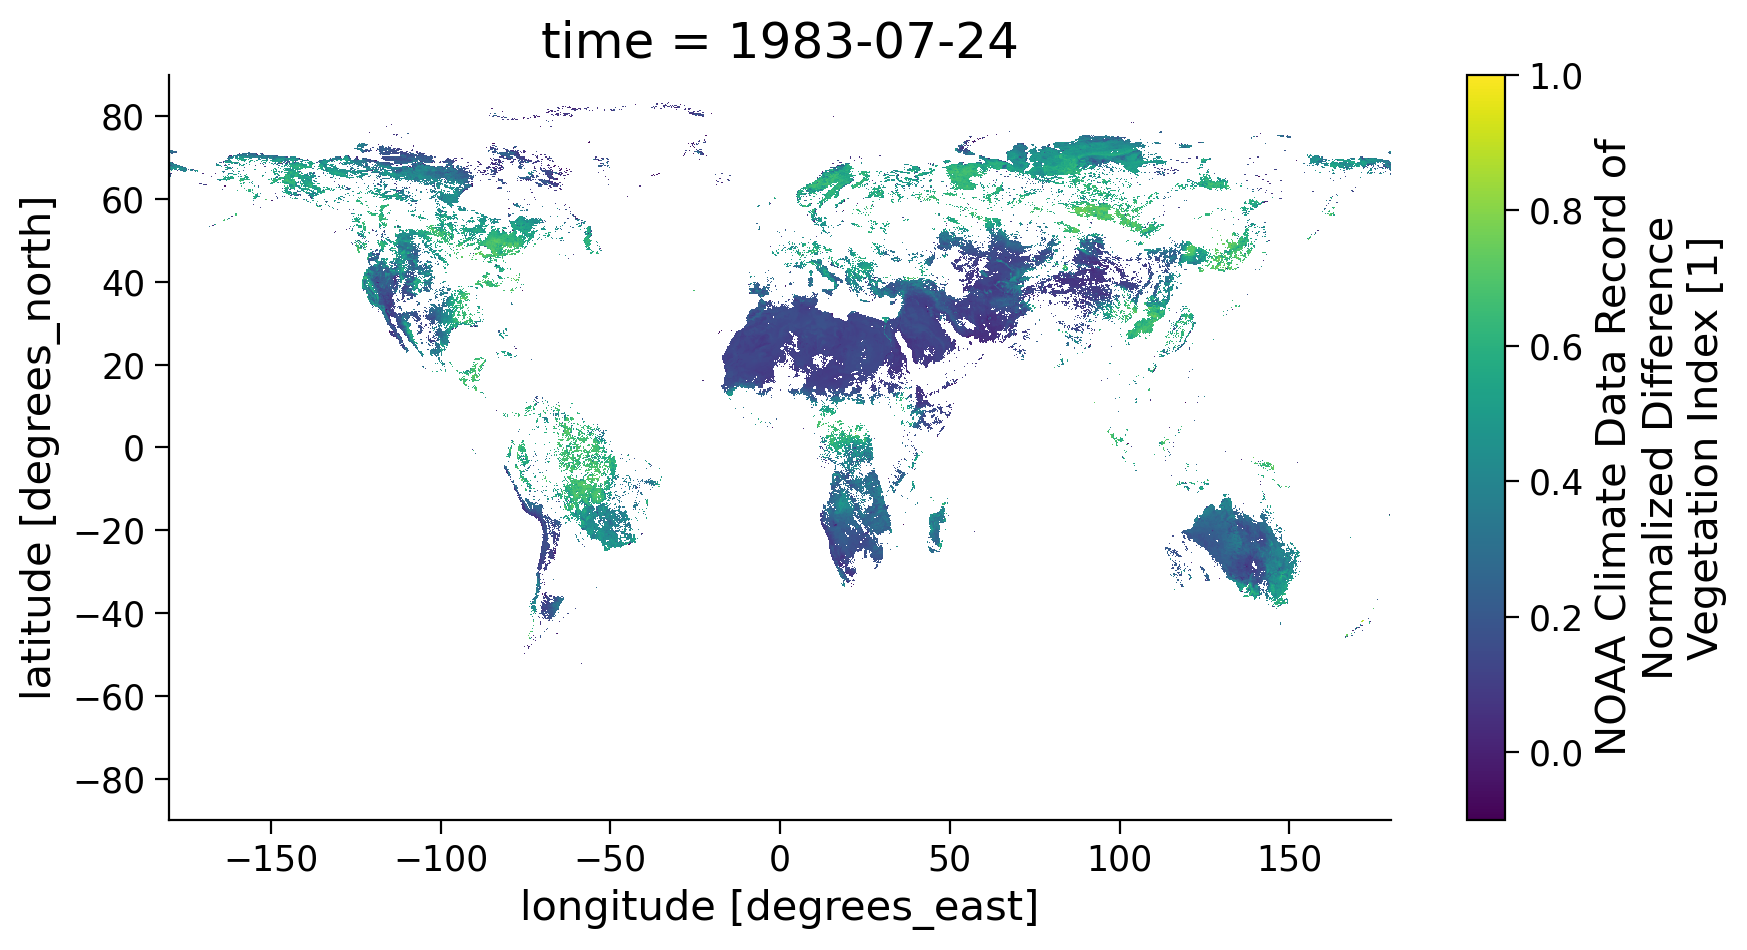

In [23]:
# to_remove solution

# define the date of your interest YYYYMMDD (e.g., 20030701)
date_sel_exercise = datetime.datetime(1983,7,24,0) # select a desired date and hours (midnight is zero)

# locate the data in the AWS S3 bucket
# hint: use the file pattern that we described
file_location_exercise = fs.glob('s3://noaa-cdr-ndvi-pds/data/'+
                        date_sel_exercise.strftime('%Y')+'/AVHRR-Land_v005_AVH13C1_*'+
                                 date_sel_exercise.strftime('%Y%m%d')+'_c*.nc')

# open file connection to the file in AWS S3 bucket and Use xarray to open the NDVI CDR file
ds_exercise = xr.open_dataset(pooch.retrieve('http://s3.amazonaws.com/'+file_location_exercise[0],known_hash=None )) # open the file


# get the QA value and extract the high quality data mask and Mask NDVI data to keep only high quality value
# hint: reuse the get_quality_info helper function we defined
ndvi_masked_exercise = ds_exercise.NDVI.where(get_quality_info(ds_exercise.QA))

# plot high quality NDVI data
# hint: use plot() function
ndvi_masked_exercise.coarsen(latitude=5).mean().coarsen(longitude=5).mean().plot(vmin=-0.1, vmax=1.0, aspect=1.8, size=5)


# **Summary**

In this tutorial, you successfully accessed and visualized one of the most commonly used remotely sensed climate datasets for land applications! In addition, you should now:

* Understand the file organization pattern to help you identify the data that you are interested in.
* Understand thow to extract only the high quality data using quality flags provided with the datasets.
* Know how to apply a quality flag mask and plot the resulting data.

In the next tutorial, you will explore how to perform time series analysis, including calculating a climatology and anomaly with precipitation data.


# **Resources**

Data from this tutorial can be accessed [here](https://noaa-cdr-ndvi-pds.s3.amazonaws.com/index.html#data/).